<a href="https://colab.research.google.com/github/sayedmohamedscu/skin-lesion-classifier-/blob/master/Train_the_skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# main libraries

In [0]:
import cv2
import numpy as np
from keras.applications import VGG16
from keras.applications import MobileNet
from keras.applications.inception_v3 import InceptionV3
import keras
from keras import models
from keras import layers
from keras.layers import Dense,GlobalAveragePooling2D,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,Input
from keras import optimizers
from keras.models import Model
from keras.models import Sequential

Using TensorFlow backend.


In [74]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(
      rescale=1./255,
rotation_range=20,
    
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        '/content/train',
        # All images will be resized to 240*240
        target_size=(160, 160),
        batch_size=80,
        shuffle=True,
        class_mode='categorical')
train_generator2 = train_datagen.flow_from_directory(
        # This is the target directory
        '/content/hsv_train',
        # All images will be resized to 240*240
        target_size=(160, 160),
        batch_size=80,
        shuffle=True,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
    '/content/test',
        
        target_size=(160, 160),
        batch_size=30,
        shuffle=True,
        class_mode='categorical')
validation_generator2 = test_datagen.flow_from_directory(
    '/content/hsv_test',
        
        target_size=(160, 160),
        batch_size=30,
        shuffle=True,
        class_mode='categorical')

Found 8022 images belonging to 7 classes.
Found 8022 images belonging to 7 classes.
Found 1993 images belonging to 7 classes.
Found 1993 images belonging to 7 classes.


# VGG16 MODEL (transfer learning)

In [59]:
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(160, 160, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [60]:
x=base_model.output
from keras.models import Model
x = Conv2D(100, kernel_size = (3,3), padding = 'valid')(x)
#x=MaxPooling2D(pool_size=(2, 2))(x)
#x = keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x=Dropout(0.5)(x)


x = Dense(50, activation='relu')(x)
x=Dropout(0.2)(x)

x = Dense(7 , activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=x)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [0]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'conv2d_5':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [61]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [64]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.1),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=102,
      epochs=15,
      
      validation_data=validation_generator,
      validation_steps=70)


Epoch 1/15


KeyboardInterrupt: ignored

the lose is very high and the accurcy still not usefull

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(160, 160, 3)
[[4.2647123e-05 2.7084351e-04 4.5431554e-03 6.6757202e-05 2.0494895e-02
  1.0000000e+00 6.1719483e-03]]
5


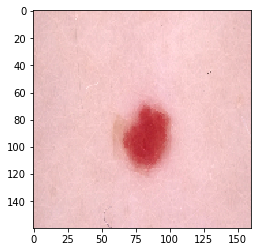

In [34]:
import numpy as np
%matplotlib inline
from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
img_path = "/content/test/vasc/ISIC_0025197.jpg"
img = image.load_img(img_path, target_size=(160, 160))
print(type(img))
plt.imshow(img)


x = image.img_to_array(img)
x=x/255
print(type(x))
print(x.shape)
x = np.expand_dims(x, axis=0)
x=x.reshape(1,160,160,3)
#k
predictions = model.predict(x)     # Vector of probabilities
print(predictions)
print(np.argmax(predictions))
#5 akiec

#MobileNet VGG16 MODEL (transfer learning)

In [0]:
base_model=MobileNet(weights='imagenet',include_top=False,input_shape=(160, 160, 3)) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.4)(x)

x=Dense(300,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better result
x=Dropout(0.4)(x)
x=BatchNormalization()(x)
x=Dense(100,activation='relu')(x) #dense layer 2
x=Dropout(0.4)(x)

x=Dense(50,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation

In [66]:
from keras.models import Model

model=Model(inputs=base_model.input,outputs=preds)
print(len(model.layers[:]))
for layer in model.layers[:85]:
    layer.trainable=False
for layer in model.layers[85:]:
    layer.trainable=True
model.summary()

96
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_______

In [67]:
from keras import models
from keras import layers
from keras import optimizers
import keras

from keras import backend as K
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=102,
      epochs=15,
      
      validation_data=validation_generator,
      validation_steps=70)



Epoch 1/15
102/102 [==============================] - 126s 1s/step - loss: 1.3360 - acc: 0.5977 - val_loss: 1.1612 - val_acc: 0.6769
Epoch 2/15
102/102 [==============================] - 113s 1s/step - loss: 1.1475 - acc: 0.6630 - val_loss: 1.0536 - val_acc: 0.6759
Epoch 3/15
102/102 [==============================] - 113s 1s/step - loss: 1.0764 - acc: 0.6650 - val_loss: 1.0004 - val_acc: 0.6702
Epoch 4/15
102/102 [==============================] - 113s 1s/step - loss: 1.0247 - acc: 0.6714 - val_loss: 0.9952 - val_acc: 0.6702
Epoch 5/15
102/102 [==============================] - 113s 1s/step - loss: 0.9969 - acc: 0.6731 - val_loss: 0.9610 - val_acc: 0.6793
Epoch 6/15
102/102 [==============================] - 113s 1s/step - loss: 0.9739 - acc: 0.6742 - val_loss: 0.9776 - val_acc: 0.6759
Epoch 7/15
102/102 [==============================] - 113s 1s/step - loss: 0.9656 - acc: 0.6777 - val_loss: 1.0092 - val_acc: 0.6687
Epoch 8/15
102/102 [==============================] - 113s 1s/step - 

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(160, 160, 3)


ValueError: ignored

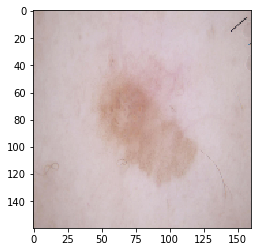

In [105]:
import numpy as np
%matplotlib inline
from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
img_path = "/content/test/df/ISIC_0029039.jpg"
img = image.load_img(img_path, target_size=(160, 160))
print(type(img))
plt.imshow(img)


x = image.img_to_array(img)
#x=x/255
print(type(x))
print(x.shape)
#x = np.expand_dims(x, axis=0)
x=x.reshape(1,160,160,3)
#k
predictions = model.predict(x)     # Vector of probabilities
print(predictions)
print(np.argmax(predictions))
#5 akiec

In [96]:
model_input = Input(shape=(160, 160,3))
#x = BatchNormalization()(model_input)
#model_input2 = Input(shape=(160, 160,3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x) 
    
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)    
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)  
x = MaxPooling2D(pool_size=(2, 2))(x)    
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x) 




    
x = Dropout(0.5)(x)

              
x = Flatten()(x)
x = Dense(20, activation='linear')(x)    
x = Dropout(0.2)(x)

#y1 = Dense(7, activation='')(x)

y5 = Dense(7, activation='softmax')(x)
    
model2 = Model(input=model_input, output=y5)
model2.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 18, 18, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [98]:
from keras import models
from keras import layers
from keras import optimizers
import keras

from keras import backend as K
model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

history = model2.fit_generator(
      train_generator,
      steps_per_epoch=102,
      epochs=15,
      
      validation_data=validation_generator,
      validation_steps=70)



Epoch 1/15
102/102 [==============================] - 128s 1s/step - loss: 1.1514 - acc: 0.6652 - val_loss: 1.0909 - val_acc: 0.6721
Epoch 2/15
102/102 [==============================] - 113s 1s/step - loss: 1.1008 - acc: 0.6690 - val_loss: 1.0470 - val_acc: 0.6774
Epoch 3/15
102/102 [==============================] - 113s 1s/step - loss: 1.0564 - acc: 0.6670 - val_loss: 1.0120 - val_acc: 0.6764
Epoch 4/15
102/102 [==============================] - 113s 1s/step - loss: 1.0155 - acc: 0.6700 - val_loss: 1.0162 - val_acc: 0.6620
Epoch 5/15
102/102 [==============================] - 113s 1s/step - loss: 0.9992 - acc: 0.6701 - val_loss: 0.9898 - val_acc: 0.6707
Epoch 6/15
102/102 [==============================] - 113s 1s/step - loss: 0.9762 - acc: 0.6684 - val_loss: 0.9418 - val_acc: 0.6740
Epoch 7/15
102/102 [==============================] - 113s 1s/step - loss: 0.9617 - acc: 0.6710 - val_loss: 0.9019 - val_acc: 0.6860
Epoch 8/15
102/102 [==============================] - 113s 1s/step - 

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(160, 160, 3)
[[0.04724947 0.21487764 0.20293675 0.02537245 0.04120496 0.44573402
  0.02262477]]
5


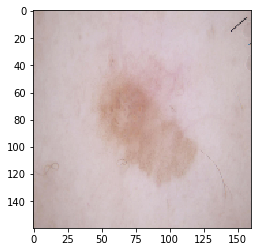

In [104]:
import numpy as np
%matplotlib inline
from keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
img_path = "/content/test/df/ISIC_0029039.jpg"
img = image.load_img(img_path, target_size=(160, 160))
print(type(img))
plt.imshow(img)


x = image.img_to_array(img)
x=x/255
print(type(x))
print(x.shape)
#x = np.expand_dims(x, axis=0)
x=x.reshape(1,160,160,3)
#k
predictions = model2.predict(x)     # Vector of probabilities
print(predictions)
print(np.argmax(predictions))
#5 akiec